# **Section 4: Decision Trees**

*Intuition:* nested `if` statements.

In which variable we split? We want to maximize the information gain. In order to measure the information gain, we need to use the information entropy:

\begin{align}
H(p) = E[-\log_2 p ] = - \sum_{c \in C} p(c) \log_2 p(c)
\end{align}


The information gain is defined as:

\begin{align}
IG(p,s) = H(p) - H(p|X < s) P(X < s) - H(p|X \geq s) P(X \geq s)
\end{align}

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/OnlineLearning/UdemyCourses/LogisticRegression/

Mounted at /content/drive
/content/drive/MyDrive/OnlineLearning/UdemyCourses/LogisticRegression


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import train_test_split

In [3]:
def entropy(p):
  if p == 0 or 1-p == 0:
    return 0
  else:
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

def calculate_information_gain(y_left,y_right):
  p1 = sum(y_left) / len(y_left)
  p2 = sum(y_right) / len(y_right)
  p = (sum(y_left)+sum(y_right)) / (len(y_left) + len(y_right))
  P = len(y_left) / (len(y_left) + len(y_right))

  return entropy(p) - P*entropy(p1) - (1-P)*entropy(p2)

In [10]:
# Classes for nodes
class TreeNode:
  def __init__(self,depth,max_depth):
    self.depth = depth
    self.max_depth = max_depth
    self.condition = None
    self.left_node = None
    self.right_node = None
    self.left_prediction = np.nan
    self.right_prediction = np.nan

  # a static function to calculate best split along
  def find_best_1d_split(self,X_sorted,y_sorted):
    split_value = np.nan
    max_information_gain = 0
    for i,x in enumerate(X_sorted):
      if i >= 1 and y_sorted[i] != y_sorted[i-1]:
        information_gain = calculate_information_gain(y_sorted[:i],y_sorted[i:])
        if information_gain > max_information_gain:
          max_information_gain = information_gain
          split_value = 0.5 * (X_sorted[i-1] + X_sorted[i])
    return split_value, max_information_gain

  # a static function to find the best split 
  def find_best_split(self,X,y):
    sortings = X.argsort(axis=0).T

    max_information_gain = 0
    best_split_value = np.nan
    best_split_index = -1
    for i,sorting in enumerate(sortings):
      X_sorted = X[sorting]
      y_sorted = y[sorting]
      split_value, information_gain = self.find_best_1d_split(X_sorted[:,i],y_sorted)
      if information_gain > max_information_gain:
        max_information_gain = information_gain
        best_split_value = split_value
        best_split_index = i
    return best_split_index,best_split_value 

  def fit(self,X,y):
    # base cases:
    # 1. only one sample sample: predict that sample's label
    if len(y) == 1:
      self.condition = lambda x: True # no splitting, will always predict left node
      self.left_prediction = y[0]
    # 2. all samples with same label, predict this label
    elif y.mean() == 1 or y.mean() == 0:
      self.condition = lambda x: True
      self.left_prediction = y.mean()
    else:
      split_index,split_value = self.find_best_split(X,y)
      # 3. max information gain = 0, make this leaf a node
      if split_index == -1 or np.isnan(split_value):
        self.condition = lambda x: True # no splitting, will always predict left node
        self.left_prediction = np.round(y.mean())
      else:
        self.condition = lambda x : x[split_index] < split_value
        X_col = X[:,split_index]

        X_left, y_left = X[X_col < split_value], y[X_col < split_value]
        X_right, y_right = X[X_col > split_value], y[X_col > split_value]
      
        # 4. max_depth reached
        if self.depth == self.max_depth:
          self.left_prediction = np.round(y_left.mean())
          self.right_prediction = np.round(y_right.mean())
        else:
          self.left_node = TreeNode(self.depth+1,self.max_depth)
          self.right_node = TreeNode(self.depth+1,self.max_depth)
          self.left_node.fit(X_left,y_left)
          self.right_node.fit(X_right,y_right)

  def predict_one(self,x):
    if self.condition(x):
      if self.left_node:
        return self.left_node.predict_one(x)
      else:
        return self.left_prediction
    else:
      if self.right_node:
        return self.right_node.predict_one(x)
      else:
        return self.right_prediction

In [5]:
# Class for binary classification with decision tree
class DecisionTree:
  def fit(self,X,y,max_depth=10):
    self.tree = TreeNode(0,max_depth)
    self.tree.fit(X,y)
  
  def predict(self,X):
    if X.ndim == 2:
      predictions = np.zeros(len(X)) 
      for i,x in enumerate(X):
        predictions[i] = self.tree.predict_one(x)
      return predictions
    else:
      return self.tree.predict_one(X)
  
  def score(self,X,y):
    return np.mean(self.predict(X) == y)

In [6]:
# Testing using the Donut dataset

N = 1000

#Set mean radii for the two categories
R1 = 10.0
R2 = 20.0

#Set variance of radii for the two categories
std1 = 2.0
std2 = 2.0

x1 = []
x2 = []
y = []

# Sample radii for both categories
r1 = R1 + std1*np.random.randn(N)
r2 = R2 + std2*np.random.randn(N)

# Sample angles
theta1 = np.random.uniform(0,2*np.pi,N)
theta2 = np.random.uniform(0,2*np.pi,N)

# Going from polar coordinates to cartesian coordinates
x1.extend(r1*np.cos(theta1))
x2.extend(r1*np.sin(theta1))
y.extend(np.ones(N))
x1.extend(r2*np.cos(theta2))
x2.extend(r2*np.sin(theta2))
y.extend(np.zeros(N))

X = np.array([x1,x2]).T
y = np.array(y)

In [7]:
# Splitting the generated data to train and test sets

X_train, y_train, X_test, y_test = train_test_split(X,y, test_ratio=0.3)

In [8]:
model = DecisionTree()
model.fit(X_train,y_train,max_depth=10)
print("Train score:",model.score(X_train,y_train))
print("Test score:",model.score(X_test,y_test))

Train score: 1.0
Test score: 0.9633333333333334


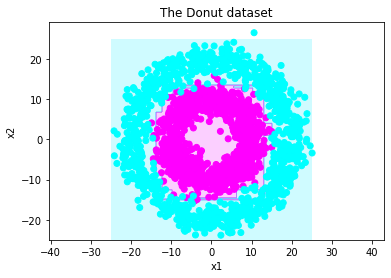

In [9]:
x_plot = y_plot = np.linspace(-25, 25, 200)

z = np.array([model.predict(np.array([i,j])) for j in y_plot for i in x_plot])
Z = z.reshape(200,200)

mesh_x, mesh_y = np.meshgrid(x_plot, y_plot)

ax = plt.axes(xlabel='x1',ylabel='x2',title='The Donut dataset')
ax.axis('equal') # Setting axis scales equal, so the donut is really circular

plt.contourf(x_plot,y_plot,Z,alpha=0.2,cmap='cool')
plt.scatter(X[:,0],X[:,1],c=y,cmap='cool')